# ML course : Assignment 3 ,  flowers classification with CNN using  YOLOv5
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scipy.io
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, MaxPool2D,BatchNormalization,Dropout
from keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#tf.keras.mixed_precision.set_global_policy('mixed_float16')
np.random.seed(1)
tf.random.set_seed(1)

HOME_DIR = '/content/'           ### Modify this according to your local env.
IMAGES_DIR = HOME_DIR+'jpg/'
img_width, img_height = 224, 224
batch_size = 8
epochs = 15
LR=0.0001

In [62]:
%cd $HOME_DIR

/content


In [63]:
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz' --no-check-certificate
!wget 'https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat' --no-check-certificate

--2023-07-16 09:38:14--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-07-16 09:38:15--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz.1’

102flowers.tgz.1    100%[===================>] 328.89M  14.5MB/s    in 25s     

2023-07-16 09:38:41 (13.4 MB/s) - ‘102flowers.tgz.1’ saved [344862509/344862509]

--2023-07-16 09:38:41--  https://www.robots.ox.ac.uk/~vgg/data/f

In [64]:
!tar -xzf '102flowers.tgz'

In [4]:
mat = scipy.io.loadmat(HOME_DIR+'imagelabels.mat')     # read labels from a MATLAB format to Array
labels=mat['labels'].reshape(-1,1).tolist()
len(labels)

8189

In [5]:
print(min(labels),max(labels))
print(list(np.unique(np.array(labels))))

[1] [102]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]


In [6]:
image_list= sorted(os.listdir(IMAGES_DIR))
image_list[:5]

['image_00001.jpg',
 'image_00002.jpg',
 'image_00003.jpg',
 'image_00004.jpg',
 'image_00005.jpg']

In [7]:
l=[]
y=[]
for idx,i in enumerate(image_list):
  current_idx=int(i.split('_')[1][:5])

  if idx+1 != current_idx:
    assert ('indexing of images and labels do not match ')
  current_label=labels[idx][0]    #   labels are between 1-102 will be LAbelEncoded later
  l.append([idx,i,current_label])
  y.append(current_label)

df_y=pd.DataFrame(y,columns=['label'])
num_classes=df_y['label'].nunique()
print(l[:5])
print('num_classes=',num_classes)

[[0, 'image_00001.jpg', 77], [1, 'image_00002.jpg', 77], [2, 'image_00003.jpg', 77], [3, 'image_00004.jpg', 77], [4, 'image_00005.jpg', 77]]
num_classes= 102


In [8]:
df= pd.DataFrame(l,columns=['id','filename','label'])
df.drop('id',axis=1,inplace=True)
df.to_csv('flower102_labels.csv',index=False)

# VGG

48 images of label 102 ['image_08000.jpg', 'image_08001.jpg', 'image_08002.jpg', 'image_08003.jpg', 'image_08004.jpg', 'image_08005.jpg', 'image_08006.jpg', 'image_08007.jpg', 'image_08008.jpg', 'image_08009.jpg', 'image_08010.jpg', 'image_08011.jpg', 'image_08012.jpg', 'image_08013.jpg', 'image_08014.jpg', 'image_08015.jpg', 'image_08016.jpg', 'image_08017.jpg', 'image_08018.jpg', 'image_08019.jpg', 'image_08020.jpg', 'image_08021.jpg', 'image_08022.jpg', 'image_08023.jpg', 'image_08024.jpg', 'image_08025.jpg', 'image_08026.jpg', 'image_08027.jpg', 'image_08028.jpg', 'image_08029.jpg', 'image_08030.jpg', 'image_08031.jpg', 'image_08032.jpg', 'image_08033.jpg', 'image_08034.jpg', 'image_08035.jpg', 'image_08036.jpg', 'image_08037.jpg', 'image_08038.jpg', 'image_08039.jpg', 'image_08040.jpg', 'image_08041.jpg', 'image_08042.jpg', 'image_08043.jpg', 'image_08044.jpg', 'image_08045.jpg', 'image_08046.jpg', 'image_08047.jpg']
label 77 224 224
label 77 224 224
label 77 224 224
label 77 224 

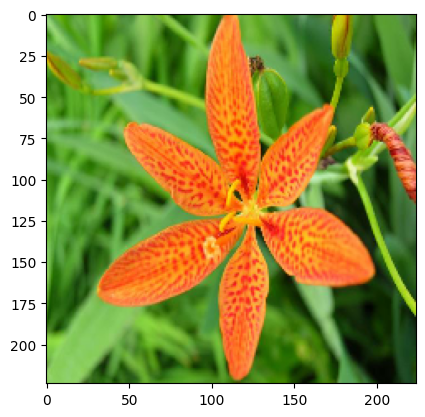

In [9]:
# #####  verification that label and image match
target_label=102
flower102 = [i[1] for i in l if i[2]==target_label ]
print(len(flower102),'images of label',target_label,flower102)
for i in range(5):
  image_file = IMAGES_DIR + flower102[i]
  image = load_img(image_file,target_size=(img_width, img_height))
  print('label',y[i],image.width,image.height)
  plt.imshow(image)

In [10]:
# # load all images to array
arr=[]
for i in image_list:
  image_file = IMAGES_DIR + i
  image = load_img(image_file,target_size=(img_width, img_height))
  input_arr = img_to_array(image)
  arr.append(input_arr)
X = np.array(arr)

In [11]:
# Convert labels to zero-based indexing
Y = df_y.values.flatten() - 1  # Subtracting 1 to shift from 1-based indexing to 0-based indexing

# Convert categorical labels to one-hot encoded vectors
Y_HOT = to_categorical(Y)

# Split the data into training and testing subsets
# x_ids: Input samples indices (since splitting on X crashes the notebook), Y_HOT: One-hot encoded labels matrix
x_ids = list(range(len(X)))
X_train_idx, X_test_idx, y_train, y_test = train_test_split(x_ids, Y_HOT, stratify=Y_HOT, test_size=0.25, random_state=42, shuffle=True)
# Further split the training subset into training and validation subsets
X_train_idx, X_valid_idx, y_train, y_valid = train_test_split(X_train_idx, y_train, test_size=0.33, random_state=42, shuffle=True)

# Extracting samples from X
X_train, X_valid, X_test = [], [], []
for i in X_train_idx:
  X_train.append(X[i])
for j in X_valid_idx:
  X_valid.append(X[j])
for k in X_test_idx:
  X_test.append(X[k])

In [83]:
# print('df_y',df_y.shape, df_y[-2:])
# print('Y',Y.shape,Y[-2:])
# print('Y_HOT',Y_HOT.shape,Y_HOT[-2:])

In [13]:
# print(y_train[:20].argmax(axis=1))
# print(y_valid[:20].argmax(axis=1))
# print(y_test[:20].argmax(axis=1))

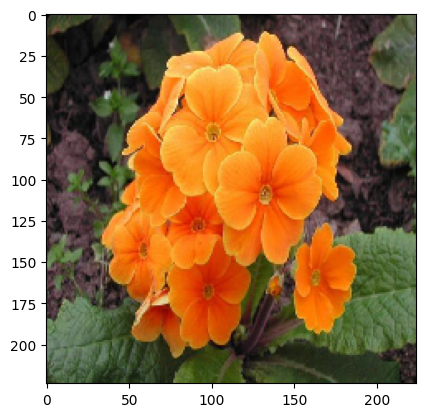

In [14]:
image=array_to_img(X_test[0])
plt.imshow(image)

In [15]:
# X_train = X_train.astype('float32') /255
# X_valid = X_valid.astype('float32') /255
# X_test = X_test.astype('float32') /255

X_test = preprocess_input(np.array(X_test))
X_valid = preprocess_input(np.array(X_valid))
X_train = preprocess_input(np.array(X_train))

print('train',X_train.shape,y_train.shape)
print('valid',X_valid.shape,y_valid.shape)
print('test',X_test.shape,y_test.shape)

train (4114, 224, 224, 3) (4114, 102)
valid (2027, 224, 224, 3) (2027, 102)
test (2048, 224, 224, 3) (2048, 102)


In [16]:
# Load the VGG19 model without the top layers (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

80134624/80134624 [==============================] - 5s 0us/step


In [17]:
# Freeze the pre-trained layers
base_model.trainable = False

base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
CONFIG = 4      #  select the CONFIG (1-4) you want to evaluate.   #3 yielded best results

In [19]:
# Option 1 :  test accurcy 0.59

if CONFIG==1:
    model = Sequential([
        base_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(num_classes , activation='softmax')])

    # model.summary()
    EPOCHS = 10

In [20]:
# Option 2 :  test accuracy 0.79 after 10 epochs

if CONFIG==2:
    # flatten the output of the convolutional part:
    x = Flatten()(base_model.output)
    # three hidden layers
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(1000, activation='relu')(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    # creating the full model:
    model = Model(inputs=base_model.input, outputs=predictions)
    # model.summary()
    EPOCHS = 18

In [21]:
# # Option 3 :  Allow fine tuning of base model , only final dense layer with softmax
if CONFIG==3:
    base_model.trainable = True
    x = Flatten()(base_model.output) #Output obtained on vgg19 is now flattened.
    prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
    #Creating model object
    model = Model(inputs=base_model.input, outputs=prediction)
    # model.summary()
    EPOCHS = 40

In [22]:
# Option 4 :  pooling+batchnorm+ final dense layer + dropout + softmax
if CONFIG==4:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    prediction = Dense(num_classes, activation='softmax')(x) # We have 102 classes, and so, the prediction is being done
    #Creating model object
    model = Model(inputs=base_model.input, outputs=prediction)
    # model.summary()
    EPOCHS = 50

In [23]:
# # # option 5 : avgpooling + 1 dense layer with RELU,
# 0.8669
# Add custom top layers for flower classification
if CONFIG==5:
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    predictions = Dense(102, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)
    # print(model.summary())
    # from keras.utils.vis_utils import plot_model
    # plot_model(model, to_file='vgg.png')
    EPOCHS = 40

In [24]:
print('running CONFIG',CONFIG)
print(model.summary())
# Compile the model
model.compile(optimizer=Adam(learning_rate=LR),  loss='categorical_crossentropy', metrics=['accuracy'])

running CONFIG 4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 

In [25]:
from keras.callbacks import  ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.00001
                              )
mcp_save = ModelCheckpoint(filepath = HOME_DIR+str(CONFIG)+'best.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

In [26]:
tf.config.optimizer.set_jit(True)
history=model.fit(X_train, y_train, batch_size=batch_size , callbacks=[reduce_lr,mcp_save],
                  validation_data=(X_valid, y_valid), epochs=EPOCHS)

Epoch 1/50
515/515 [==============================] - 23s 22ms/step - loss: 4.0765 - accuracy: 0.1359 - val_loss: 3.1215 - val_accuracy: 0.3611 - lr: 1.0000e-04
Epoch 2/50
515/515 [==============================] - 9s 18ms/step - loss: 2.7124 - accuracy: 0.4040 - val_loss: 2.2077 - val_accuracy: 0.5264 - lr: 1.0000e-04
Epoch 3/50
515/515 [==============================] - 6s 12ms/step - loss: 1.9626 - accuracy: 0.5685 - val_loss: 1.7064 - val_accuracy: 0.6354 - lr: 1.0000e-04
Epoch 4/50
515/515 [==============================] - 6s 12ms/step - loss: 1.4851 - accuracy: 0.6726 - val_loss: 1.3808 - val_accuracy: 0.7079 - lr: 1.0000e-04
Epoch 5/50
515/515 [==============================] - 6s 12ms/step - loss: 1.1801 - accuracy: 0.7496 - val_loss: 1.1595 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 6/50
515/515 [==============================] - 6s 12ms/step - loss: 0.9402 - accuracy: 0.7941 - val_loss: 1.0196 - val_accuracy: 0.7721 - lr: 1.0000e-04
Epoch 7/50
515/515 [===================

In [27]:
# # reload the model (epoch) that got best accuracy
from keras.models import load_model
best_model = load_model(HOME_DIR+str(CONFIG)+'best.hdf5')

In [28]:
# Evaluate the model on the test data
scores = best_model.evaluate(X_test, y_test, batch_size=batch_size)
#scores = model.evaluate(test_generator.flow(X_test, y_test, batch_size=batch_size))
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

256/256 [==============================] - 3s 7ms/step - loss: 0.5161 - accuracy: 0.8716
Test loss: 0.5160707235336304
Test accuracy: 0.87158203125


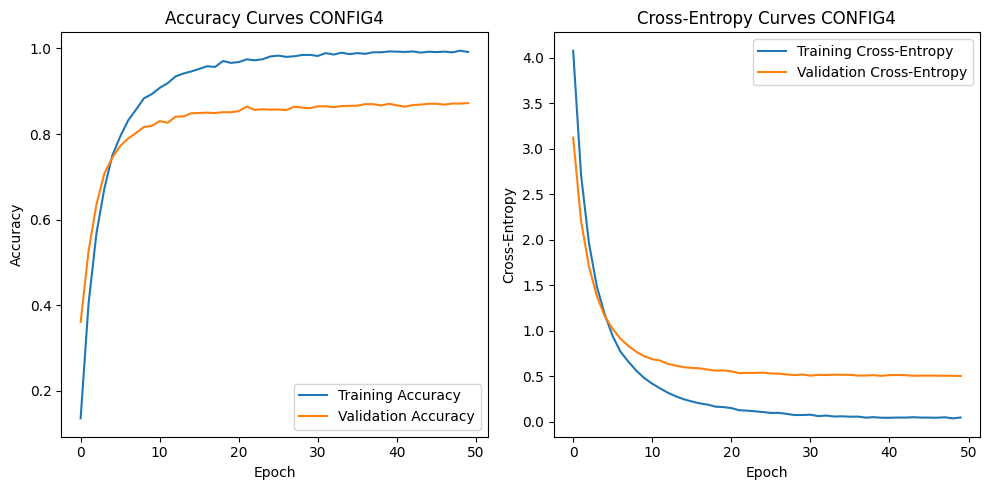

In [29]:
# from matplotlib import pyplot as plt
# Plot accuracy graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves CONFIG'+str(CONFIG))
plt.legend()

# Plot cross-entropy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Cross-Entropy')
plt.plot(history.history['val_loss'], label='Validation Cross-Entropy')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy Curves CONFIG'+str(CONFIG))
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
y_pred = best_model.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

64/64 [==============================] - 5s 19ms/step


Text(0.5, 23.52222222222222, 'Predicted label')

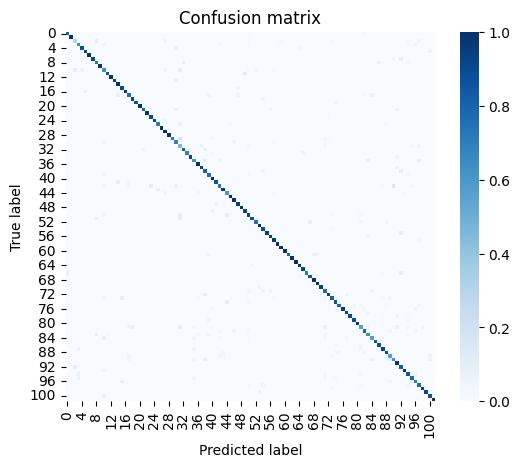

In [31]:
# # axis_labels = list(CLASSES.values())
import seaborn as sns
confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)

# Create the heatmap using seaborn
ax = sns.heatmap(confusion_normalized, cmap='Blues', square=True)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")

In [84]:
# free memory

del X_train
del X_valid
del X_test
del model
del history

# YOLOv5

In [32]:
########################## YOLOv5 #######################

In [33]:
list_of_labels = [str(i) for i in range(1,103)]
print(list_of_labels)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102']


In [34]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 25.1/166.8 GB disk)


# organize folder structure for YOLO/Classify

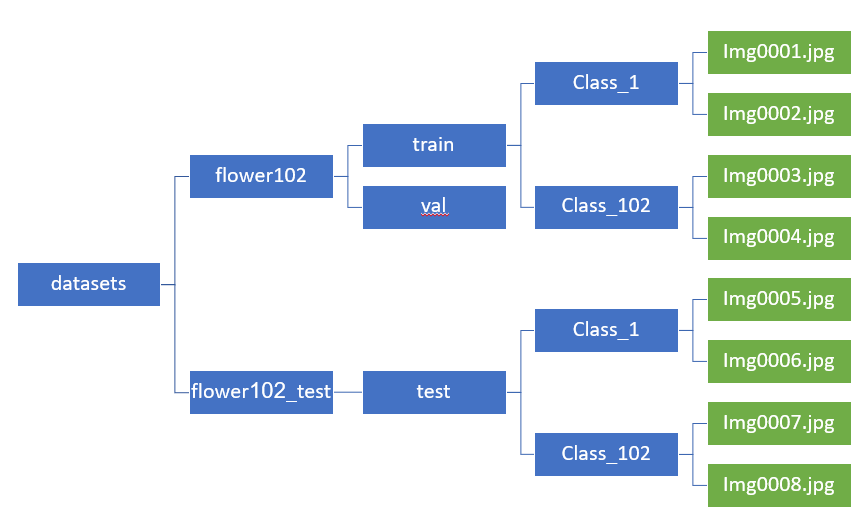

In [65]:
YOLO_DIR = HOME_DIR + 'yolov5'
DATASET_DIR = YOLO_DIR + '/datasets'
FLOWER_DIR = DATASET_DIR+'/flower102'
FLOWER_TEST_DIR = DATASET_DIR+'/flower102_test'

os.getcwd()

'/content'

In [66]:
!rm -Rf $DATASET_DIR

In [67]:
!mkdir $DATASET_DIR

!mkdir $FLOWER_DIR

!mkdir $FLOWER_TEST_DIR

In [68]:
# arrange files in the corect folder structure

for group in ['train','val','test']:
    if group=='test':
        new_group = FLOWER_TEST_DIR+'/' + group
    else:
        new_group = FLOWER_DIR+'/' + group
    if not os.path.exists(new_group):
        os.mkdir(new_group)
        for c in list_of_labels:
            new_dir = new_group + '/class_' + c
            if not os.path.exists(new_dir):
                os.mkdir(new_dir)


In [69]:
df_source_image_list=pd.read_csv(HOME_DIR+'flower102_labels.csv')
df_source_image_list

,filename,label
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77
...,...,...
8184,image_08185.jpg,62
8185,image_08186.jpg,62
8186,image_08187.jpg,62
8187,image_08188.jpg,62


In [70]:
# split into train/val/test

df_x_train,df_x_test,df_y_train,df_y_test = train_test_split(df_source_image_list,df_y,test_size=0.25,random_state=42,shuffle=True,stratify=df_y)
df_x_train,df_x_valid,df_y_train,df_y_valid = train_test_split(df_x_train,df_y_train,test_size=0.33,random_state=42,shuffle=True,stratify=df_y_train)

print('train',df_x_train.shape,df_y_train.shape)
print('valid',df_x_valid.shape,df_y_valid.shape)
print('test',df_x_test.shape,df_y_test.shape)

train (4114, 2) (4114, 1)
valid (2027, 2) (2027, 1)
test (2048, 2) (2048, 1)


In [71]:
dfs_dict = {'train': df_x_train, 'val': df_x_valid, 'test': df_x_test}
for key in dfs_dict.keys():
    print('moving images to ',key,' folder .....')
    df = dfs_dict[key]
    for _, row in df.iterrows():
        source = IMAGES_DIR + row['filename']
        if key == 'test':
            dest1 = FLOWER_TEST_DIR+'/' + key + '/class_' + str(row['label']) + '/' + row['filename']
        else:
            dest1 = FLOWER_DIR+'/' + key + '/class_' + str(row['label']) + '/' + row['filename']
        if os.path.exists(source):
            # print('moving ' + str(row) + ' from ' + str(source) + ' to ' + str(dest1))
            !mv $source $dest1
        else:
            print(f"File not found: {source}")


In [58]:

from utils.downloads import attempt_download

# p5 = ['n', 's', 'm', 'l', 'x']  # P5 models
p5 = [ 's']  # only small model
cls = [f'{x}-cls' for x in p5]  # classification models

for x in cls:
    attempt_download(f'weights/yolov5{x}.pt')

100%|██████████| 10.5M/10.5M [00:02<00:00, 4.75MB/s]



In [ ]:
# model = torch.hub.load('ultralytics/yolov5', 'custom', path='weights/yolov5s-cls.pt')
# # model = torch.hub.load('ultralytics/yolov5:classifier', 'custom', path='weights/yolov5s-cls.pt')

In [ ]:
# # Freeze
# freeze = [f'model.{x}.' for x in range(9)]  # layers to freeze
# for k, v in model.named_parameters():
#     v.requires_grad = True  # train all layers
#     if any(x in k for x in freeze):
#         print(f'freezing {k}')
#         v.requires_grad = False

In [59]:
# train the model for classification task
%cd $YOLO_DIR
!python classify/train.py --model yolov5s-cls.pt --data $FLOWER_DIR --epochs 100 --img 384 --pretrained weights/yolov5s-cls.pt

/content/yolov5
classify/train: model=yolov5s-cls.pt, data=/content/yolov5/datasets/flower102, epochs=100, batch_size=64, imgsz=384, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=weights/yolov5s-cls.pt, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

TensorBoard: Start with 'tensorboard --logdir runs/train-cls', view at http://localhost:6006/
albumentations: RandomResizedCrop(p=1.0, height=384, width=384, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1), HorizontalFlip(p=0.5), ColorJitter(p=0.5, brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[0, 0]), Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0)

In [60]:
# set the correct weights file of YOLO best model - according to the run number (runs/train-cls/exp{num}/weights/best.pt)
BEST = 'runs/train-cls/exp/weights/best.pt'

In [73]:
# evaluate the model on TEST set
%cd $YOLO_DIR
# !python classify/val.py --weights runs/train-cls/exp4/weights/best.pt --data datasets/flower102_test
!python classify/val.py --weights $BEST --data $FLOWER_TEST_DIR

/content/yolov5
classify/val: data=/content/yolov5/datasets/flower102_test, weights=['runs/train-cls/exp/weights/best.pt'], batch_size=128, imgsz=224, device=, workers=8, verbose=True, project=runs/val-cls, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
testing: 100% 16/16 [00:02<00:00,  7.38it/s]
                   Class      Images    top1_acc    top5_acc
                     all        2048        0.58       0.831
                 class_1          10         0.7           1
                class_10          11       0.818           1
               class_100          12       0.833       0.917
               class_101          14       0.143       0.643
               class_102          12       0.417       0.583
                class_11          22       0.318       0.591
                clas

Inference on test

In [86]:
!python classify/predict.py --weights runs/train-cls/exp/weights/best.pt --source /content/yolov5/datasets/flower102_test/test/class_33

classify/predict: weights=['runs/train-cls/exp/weights/best.pt'], source=/content/yolov5/datasets/flower102_test/test/class_33, data=data/coco128.yaml, imgsz=[224, 224], device=, view_img=False, save_txt=False, nosave=False, augment=False, visualize=False, update=False, project=runs/predict-cls, name=exp, exist_ok=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
image 1/11 /content/yolov5/datasets/flower102_test/test/class_33/image_06446.jpg: 224x224 class_33 0.86, class_35 0.06, class_77 0.05, class_10 0.01, class_28 0.00, 3.2ms
image 2/11 /content/yolov5/datasets/flower102_test/test/class_33/image_06447.jpg: 224x224 class_33 0.69, class_68 0.18, class_28 0.05, class_35 0.02, class_9 0.01, 3.3ms
image 3/11 /content/yolov5/datasets/flower102_test/test/class_33/image_06450.jpg: 224x224 class_67 0.32, cla

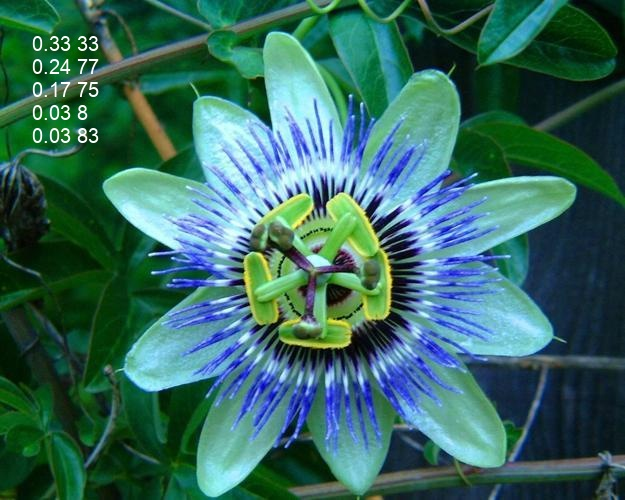

In [ ]:
%cd $YOLO_DIR

/content/yolov5


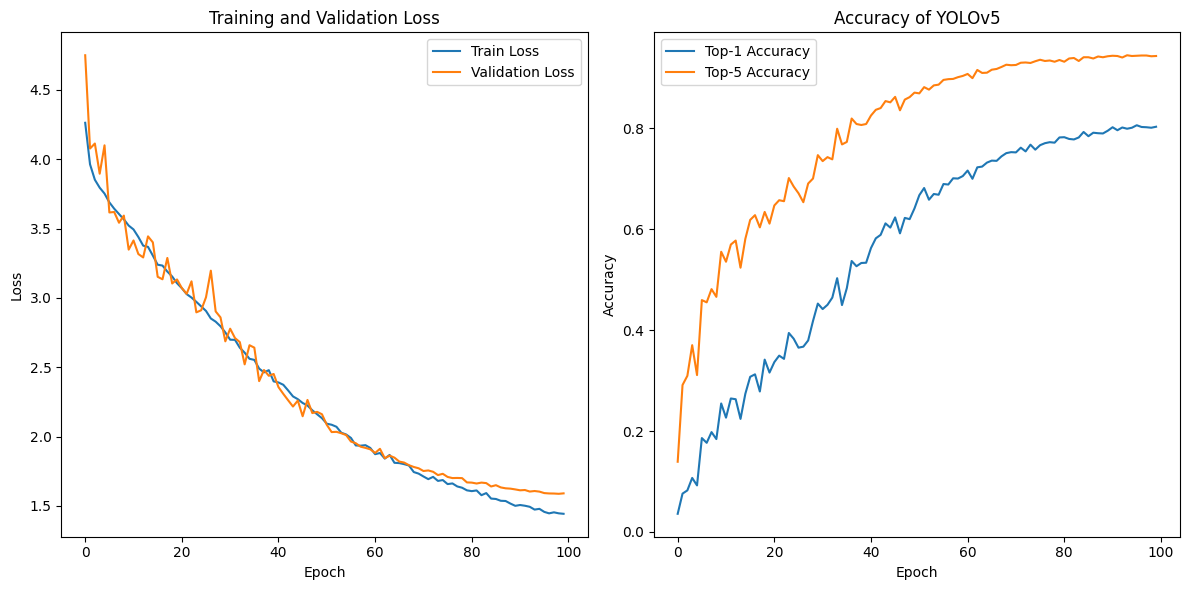

In [74]:
# set resuts file according to evaluation number /runs/train-cls/exp{num}/results.csv

RESULTS = YOLO_DIR+'/runs/train-cls/exp/results.csv'

# Convert data to DataFrame
df = pd.read_csv(RESULTS, header=0)
df.columns = df.columns.str.strip()

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Training and Validation Loss
ax1.plot(df['epoch'], df['train/loss'], label='Train Loss')
ax1.plot(df['epoch'], df['val/loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot Top-1 and Top-5 Accuracy
ax2.plot(df['epoch'], df['metrics/accuracy_top1'], label='Top-1 Accuracy')
ax2.plot(df['epoch'], df['metrics/accuracy_top5'], label='Top-5 Accuracy')
ax2.set_title('Accuracy of YOLOv5')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the layout of subplots
plt.tight_layout()

# Show the plot
plt.show()

In [75]:
# model = torch.hub.load('ultralytics/yolov5', 'custom', '/sise/home/roeiza/yolov5/yolov5/runs/train-cls/exp4/weights/best.pt')
model = torch.hub.load('ultralytics/yolov5', 'custom', BEST)

print(model)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


DetectMultiBackend(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv3): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): Sequential(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): 